In [20]:
import os

base_path = '/kaggle/input/vehicle-detection-image-set/data/'
train_path = '/kaggle/working/dataset/train/'
test_path = '/kaggle/working/dataset/test/'

os.makedirs(train_path + 'vehicles', exist_ok=True)
os.makedirs(train_path + 'non-vehicles', exist_ok=True)
os.makedirs(test_path + 'vehicles', exist_ok=True)
os.makedirs(test_path + 'non-vehicles', exist_ok=True)

In [21]:
import shutil

src_vehicles_path = base_path + 'vehicles/'
src_non_vehicles_path = base_path + 'non-vehicles/'

dest_train_vehicles_path = train_path + 'vehicles/'
dest_train_non_vehicles_path = train_path + 'non-vehicles/'
dest_test_vehicles_path = test_path + 'vehicles/'
dest_test_non_vehicles_path = test_path + 'non-vehicles/'

split_ratio = 0.8

vehicle_images = os.listdir(src_vehicles_path)
non_vehicle_images = os.listdir(src_non_vehicles_path)

num_train_vehicles = int(len(vehicle_images) * split_ratio)
num_train_non_vehicles = int(len(non_vehicle_images) * split_ratio)

for img in vehicle_images[:num_train_vehicles]:
    shutil.copy(src_vehicles_path + img, dest_train_vehicles_path + img)

for img in non_vehicle_images[:num_train_non_vehicles]:
    shutil.copy(src_non_vehicles_path + img, dest_train_non_vehicles_path + img)

for img in vehicle_images[num_train_vehicles:]:
    shutil.copy(src_vehicles_path + img, dest_test_vehicles_path + img)

for img in non_vehicle_images[num_train_non_vehicles:]:
    shutil.copy(src_non_vehicles_path + img, dest_test_non_vehicles_path + img)

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.metrics import Precision, Recall, F1Score
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.applications import  MobileNetV2
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras import models, layers

In [23]:
Batch_size1 = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5], 
    channel_shift_range=50  
)
test_datagen = ImageDataGenerator(rescale=1./255
)

test_Image = test_datagen.flow_from_directory(
    '/kaggle/working/dataset/test',
    target_size=(64, 64),
    batch_size=Batch_size1,
    class_mode='binary',
    shuffle=False  
)

train_Image = train_datagen.flow_from_directory(
    '/kaggle/working/dataset/train',
    target_size=(64, 64),
    batch_size=Batch_size1,
    class_mode='binary'
)

Found 3553 images belonging to 2 classes.
Found 14207 images belonging to 2 classes.


In [24]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu', input_shape=(64, 64, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='Same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='Same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(512, activation="relu"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(64, activation="relu"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(1, activation="sigmoid"))
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1)
optimizer = Adam(learning_rate=0.0001)
cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(),Recall()])

In [25]:
Evaluate1 = cnn_model.fit(train_Image, epochs=2, validation_data=test_Image, batch_size=Batch_size1, callbacks=[early_stopping])

Epoch 1/2
444/444 [==============================] - 188s 418ms/step - loss: 0.3726 - accuracy: 0.8308 - precision_1: 0.8073 - recall_1: 0.8645 - val_loss: 0.1493 - val_accuracy: 0.9496 - val_precision_1: 0.9484 - val_recall_1: 0.9500
Epoch 2/2
444/444 [==============================] - 184s 414ms/step - loss: 0.1996 - accuracy: 0.9258 - precision_1: 0.9242 - recall_1: 0.9261 - val_loss: 0.1093 - val_accuracy: 0.9575 - val_precision_1: 0.9299 - val_recall_1: 0.9886


In [26]:
print("\nClassification Report:")
score, acc, pre, rcl = cnn_model.evaluate(test_Image)
print('Test Loss:', score * 100)
print('Test Accuracy:' ,acc * 100)
print('Test Precision:',pre * 100)
print('Test Recall:', rcl * 100)
f1_score=2 * (pre * rcl) / (rcl + rcl)
print('Test F1-Score:' ,f1_score * 100)


Classification Report:
112/112 [==============================] - 10s 89ms/step - loss: 0.1093 - accuracy: 0.9575 - precision_1: 0.9299 - recall_1: 0.9886
Test Loss: 10.925506055355072
Test Accuracy: 95.7500696182251
Test Precision: 92.99465417861938
Test Recall: 98.86298775672913
Test F1-Score: 92.99465417861938


112/112 [==============================] - 9s 82ms/step


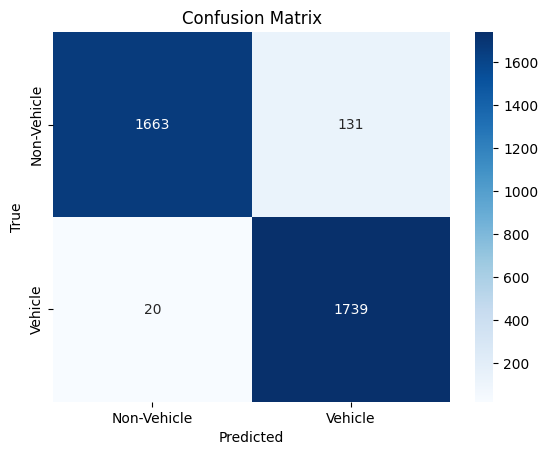

In [27]:
predictions = cnn_model.predict(test_Image)

binary_predictions = np.round(predictions)

true_labels = test_Image.classes

conf_matrix = confusion_matrix(true_labels, binary_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Vehicle', 'Vehicle'], yticklabels=['Non-Vehicle', 'Vehicle'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

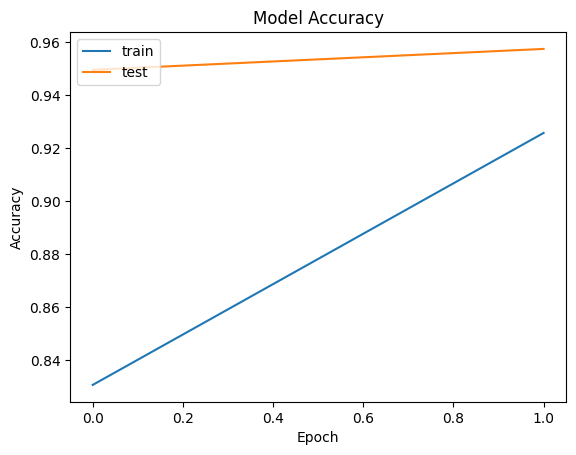

In [28]:
k = ''
if 'accuracy' in Evaluate1.history :
    k = 'accuracy'

if 'acc' in Evaluate1.history :
    k = 'acc'

if k != '' :
    plt.plot(Evaluate1.history[k])
    plt.plot(Evaluate1.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()





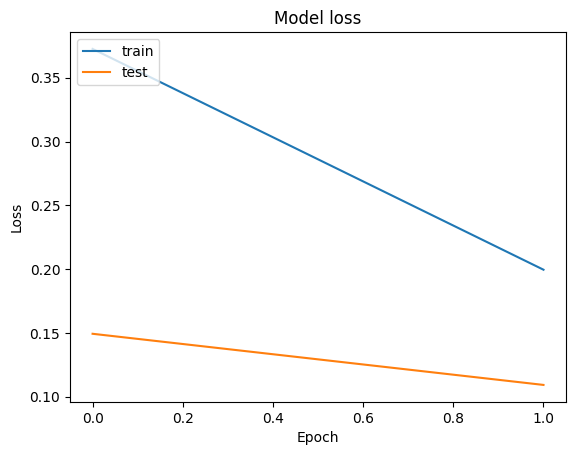

In [29]:
plt.plot(Evaluate1.history['loss'])
plt.plot(Evaluate1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


112/112 [==============================] - 9s 82ms/step


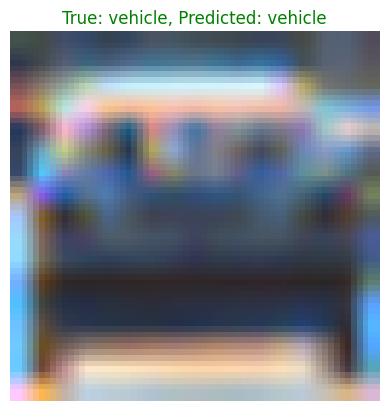

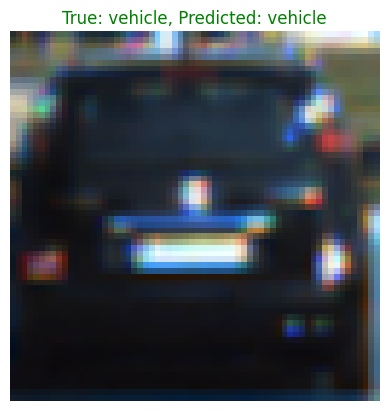

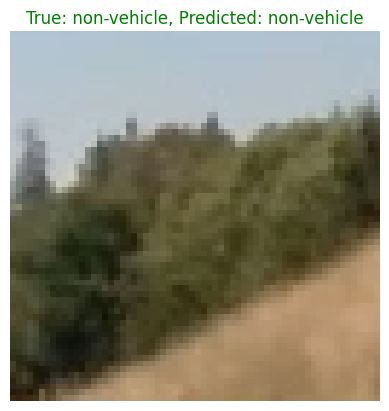

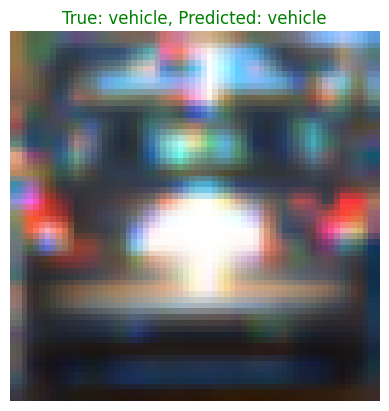

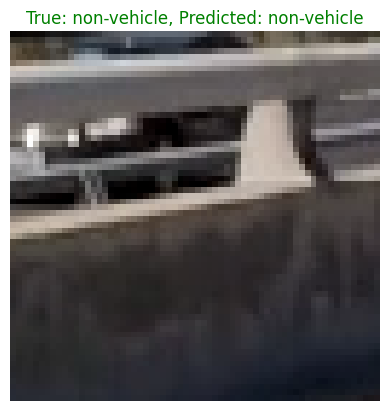

In [30]:
class_labels = {0: 'non-vehicle', 1: 'vehicle'}

def visualize_predictions(model, test_data_gen, num_samples=5):
    predictions = model.predict(test_data_gen)

    true_labels = test_data_gen.classes

    class_indices = test_data_gen.class_indices


    filenames = test_data_gen.filenames

    sample_indices = np.random.choice(len(filenames), num_samples, replace=False)

    for i in sample_indices:
        filename = filenames[i]

        true_label = class_labels[true_labels[i]]

        predicted_prob = predictions[i]
        predicted_class = int(predicted_prob > 0.5)
        predicted_label = class_labels[predicted_class]

        label_color = 'green' if true_label == predicted_label else 'red'

        img_path = os.path.join('/kaggle/working/dataset/test/', filename)
        img = plt.imread(img_path)

        plt.imshow(img)
        plt.title(f'True: {true_label}, Predicted: {predicted_label}', color=label_color)
        plt.axis('off')
        plt.show()

visualize_predictions(cnn_model, test_Image, num_samples=5)
